### Aprendizagem de Máquina - Lista 01

#### Aluno: João Victor Alves de Oliveira - 473977

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def MSE(x, y, w):
    y2 = x @ w
    return ((y - y2) ** 2).mean()


def RMSE(x, y, w):
    return MSE(x, y, w) ** 0.5


def normalize(x):
    return x / np.linalg.norm(x, axis=-1)[:, np.newaxis]


def GD(x, y, w, alpha, epochs, normalized=False):
    custos = np.zeros(epochs)
    if normalized:
        x = normalize(x)

    for epoch in range(epochs):
        y2 = x @ w
        w = w + alpha * (x.T @ (y - y2))
        custos[epoch] = MSE(x, y, w)

    return w, custos


def SGD(x, y, w, alpha, epochs, normalized=False):
    n, m = x.shape
    custos = np.zeros((epochs * n))
    if normalized:
        x = normalize(x)

    for epoch in range(epochs):
        for i in range(n):
            y2 = x[i] @ w
            error = (y[i] - y2)
            w = w + alpha * error * x[i].reshape((1, -1)).T
            custos[epoch * n + i] = MSE(x, y, w)

    return w, custos


def OLS(x, y):
    return np.linalg.solve(x.T @ x, x.T @ y)


# Questão 01

## Lendo o dataset, criando as variáveis x e y

In [20]:
dataset = np.genfromtxt('./artificial1d.csv', delimiter=',', skip_header=0)
print(dataset.shape)
n, m = dataset.shape

x = np.c_[np.ones((n, 1)), dataset[:, :m-1]]
y = dataset[:, -1].reshape((-1, 1))

print(x.shape, y.shape)

(30, 2)
(30, 2) (30, 1)


## a) Treinando o modelo com OLS

parâmetros:
[[0.06761792]
 [1.57486517]]
MSE: 0.21340090132936992


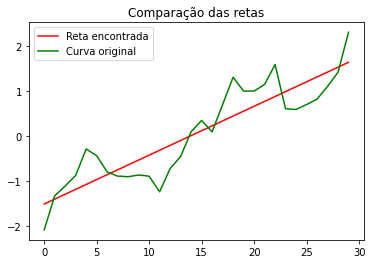

In [4]:
w = OLS(x, y)
print('parâmetros:')
print(w)
print('MSE:', MSE(x, y, w))

plt.title('Comparação das retas')
plt.plot(x @ w, color='r', label='Reta encontrada')
plt.plot(y, color='g', label='Curva original')
plt.legend()
plt.show()

## b) Treinando o modelo com GD

(2, 1)
parâmetros:
[[0.07524452]
 [1.9654975 ]]
MSE 0.2678315059587018


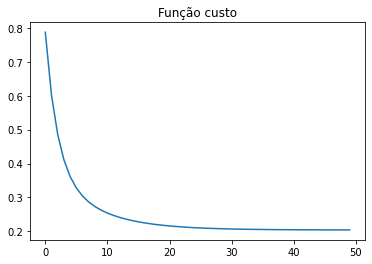

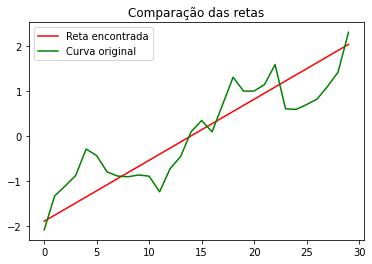

In [25]:
w = np.ones((m, 1))
print(w.shape)

alpha = 0.01
epochs = 25

w, custos = GD(x, y, w, alpha, epochs, normalized=False)

print('parâmetros:')
print(w)
print('MSE', MSE(x, y, w))

plt.title('Função custo')
plt.plot(custos)
plt.show()

plt.title('Comparação das retas')
plt.plot(x @ w, color='r', label='Reta encontrada')
plt.plot(y, color='g', label='Curva original')
plt.legend()
plt.show()

## c) Treinando o modelo com SGD

(2, 1)
parâmetros:
[[0.06976621]
 [1.54021143]]
MSE 0.21383341683500026


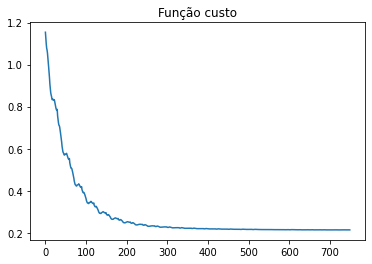

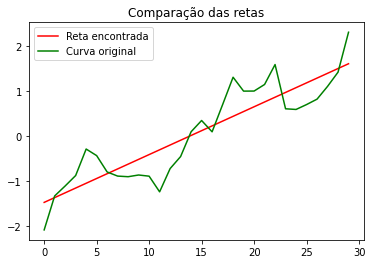

In [6]:
w = np.ones((m, 1))
print(w.shape)

alpha = 0.01
epochs = 25

w, custos = SGD(x, y, w, alpha, epochs)

print('parâmetros:')
print(w)
print('MSE', MSE(x, y, w))

plt.title('Função custo')
plt.plot(custos)
plt.show()

plt.title('Comparação das retas')
plt.plot(x @ w, color='r', label='Reta encontrada')
plt.plot(y, color='g', label='Curva original')
plt.legend()
plt.show()

# Questão 02

In [84]:
dataset = np.genfromtxt('./california.csv', delimiter=',', skip_header=0)
print(dataset.shape)
n, m = dataset.shape

seed = 161803399
np.random.seed(seed)

def shuffle(model, train_size=0.8, test_size=0.2, reseed=False):
    if reseed:
        np.random.seed(seed)

    n, m = model.shape
    np.random.shuffle(model)
    train_set, test_set = model[:int(train_size * n), :], model[int(train_size * n):, :]
    print(train_set.shape, test_set.shape)

    x1 = np.c_[np.ones((int(train_size * n), 1)), train_set[:, :m-1]]
    y1 = train_set[:, -1].reshape((-1, 1))
    x2 = np.c_[np.ones((int(test_size * n), 1)), test_set[:, :m-1]]
    y2 = test_set[:, -1].reshape((-1, 1))
    print(x1.shape, y1.shape, x2.shape, y2.shape)

    return x1, y1, x2, y2

(5000, 9)


In [94]:
models = [
    np.c_[dataset, dataset[:, 0] ** 2, dataset[:, 3] ** 3],
    np.c_[dataset, dataset[:, 7] ** 4, dataset[:, 4] ** 2, dataset[:, 6] ** 3, dataset[:, 3] ** 5],
    np.c_[dataset, dataset[:, 5] ** 3, dataset[:, 6] ** 2, dataset[:, 2] ** 2, dataset[:, 3] ** 2, dataset[:, 4] ** 3],
    np.c_[dataset, dataset[:, 0] ** 2, dataset[:, 3] ** 3, dataset[:, 7] ** 4, dataset[:, 4] ** 2, dataset[:, 6] ** 3, dataset[:, 3] ** 5],
    np.c_[dataset, dataset[:, 8] ** 2, dataset[:, 7] ** 3, dataset[:, 6] ** 4],
    np.c_[dataset, dataset[:, 4] ** 4],
    np.c_[dataset, dataset[:, 7] ** 2, dataset[:, 1] ** 2, dataset[:, 8] ** 3, dataset[:, 3] ** 3],
    np.c_[dataset, dataset[:, 0] ** 3, dataset[:, 8] ** 4, dataset[:, 4] ** 2],
    np.c_[dataset, dataset[:, 2] ** 2, dataset[:, 3] ** 3, dataset[:, 4] ** 4, dataset[:, 5] ** 5],
    np.c_[dataset, dataset[:, 3] ** 2, dataset[:, 3] ** 3, dataset[:, 3] ** 4, dataset[:, 3] ** 5, dataset[:, 4] ** 2],
    np.c_[dataset, dataset[:, 0] ** 2, dataset[:, 3] ** 3, dataset[:, 7] ** 4, dataset[:, 4] ** 2, dataset[:, 6] ** 3, dataset[:, 3] ** 5, dataset[:, 8] ** 2, dataset[:, 7] ** 3, dataset[:, 6] ** 4]
]

In [91]:
def validate_model(model):
    x1, y1, x2, y2 = shuffle(model, reseed=True)
    w = OLS(x1, y1)
    print('parâmetros:')
    print(w)
    print('RMSE:', RMSE(x2, y2, w))

    plt.title('Conjunto de treino')
    plt.plot(x1 @ w, color='r', label='Reta encontrada')
    plt.plot(y1, color='g', label='Curva original')
    plt.legend()
    plt.show()

    plt.title('Conjunto de testes')
    plt.plot(x2 @ w, color='r', label='Reta encontrada')
    plt.plot(y2, color='g', label='Curva original')
    plt.legend()
    plt.show()


(4000, 11) (1000, 11)
(4000, 11) (4000, 1) (1000, 11) (1000, 1)
parâmetros:
[[-3.10521764e+02]
 [-1.51851348e-01]
 [ 8.75113572e-02]
 [ 2.61071609e+00]
 [ 3.68425413e+01]
 [ 2.94839620e-04]
 [ 1.21681665e-02]
 [-3.17454008e+00]
 [-3.11183115e+00]
 [-1.14789612e+00]
 [-2.92728291e-02]]
RMSE: 8.044306920985768


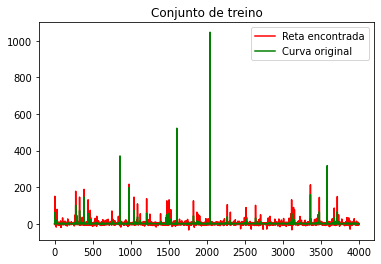

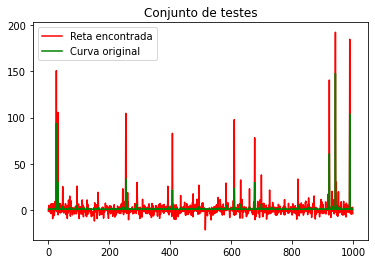

In [95]:
validate_model(models[0])